In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from pygam import LinearGAM, s, f
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def pickleLoad(file):
    with open(file,"rb") as fr:
        dataframe = pickle.load(fr)
    return dataframe


In [3]:
%run -i './getTrainTestSet/getTrainTestSet_interpolation.py' 

In [4]:
# load train, test set data

X_train = pickleLoad('./dataset/dataset_interpolation/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_interpolation/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_interpolation/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_interpolation/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_interpolation/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_interpolation/predictors.pkl')

* data preprocessing(standard scaling)

In [5]:
########## 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### model 1. multiple linear regression

* 10-fold CV

In [6]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
rmse_linearRegressionCV = np.sqrt(-scores)
rmse_lravg = rmse_linearRegressionCV.mean()
rmse_lrstd = rmse_linearRegressionCV.std()

In [7]:
print(" 10-fold cv RMSE: ", rmse_linearRegressionCV)
print("최종 CV RMSE = ", rmse_lravg)

 10-fold cv RMSE:  [5.07592046 2.30340359 5.06787404 4.33930464 3.91570853 3.83144671
 3.31735297 3.18978882 3.31262403 5.33889426]
최종 CV RMSE =  3.9692318060522425


### model 2: Random Forest

In [8]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [9]:
# CV
rmse_randomforest, parameters_randomforest = [], []
numOfEstimators = np.power(2, [3,4,5,6])
maxFeatures = [1,2,3,4,5]
for i in maxFeatures:
    for j in numOfEstimators:
        # parameter search
        model_forest = RandomForestRegressor(max_features = i, n_estimators = j, warm_start = True, random_state = 23)
        parameters_randomforest.append(model_forest.get_params)
        # 10-fold CV
        scores = cross_val_score(model_forest, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
        rmse_randomforest.append(np.sqrt(-scores))
    

In [10]:
def getCVResult(rmse_list, model_num):
    cv_rmse =  rmse_list[model_num - 1].mean()
    std = rmse_list[model_num - 1].std()

    return cv_rmse, std

In [11]:
rmse_list, std_list = [], []
for i in range(1,21):
    cv_rmse, std = getCVResult(rmse_randomforest, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 3.2554330203845048 0.6356634185421207
2 3.121148293515939 0.5611365378527597
3 3.075682489968745 0.488849630944563
4 3.0328919397700185 0.4583527937506805
5 2.9475682928270923 0.6657927370016793
6 2.8673344207279703 0.5371481029225377
7 2.844879535223791 0.5544165687517145
8 2.8140877137829365 0.560056447815798
9 2.8527923855261657 0.7253797519819571
10 2.834483726761099 0.6783436043278501
11 2.857824367579001 0.6877751912227785
12 2.8083498720391513 0.6553936540083781
13 2.9240980793610665 0.6634840852306049
14 2.8678849152038817 0.6878794910452751
15 2.859246785108786 0.7053420187242779
16 2.830136852434415 0.6504162905812015
17 2.9944874697768937 0.7005017179917812
18 2.869354671425439 0.7154249663346828
19 2.8652418628301715 0.7004806796956308
20 2.83470630989427 0.6416694641633611


#### final random forest model selection

In [12]:
rmse_list.index(min(rmse_list))

11

model 후보 1~20번 중에, 12번모델이 가장 낮은 rmse 평균값을 갖고있음을 확인할 수 있다.

따라서, 12번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [13]:
# 대표 모델의 파라미터
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=3, n_estimators=64, random_state=23,
                      warm_start=True)>

In [14]:
# 대표 모델의 평균 rmse와 std
rmse_forestavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_foreststd = std_list[rmse_list.index(min(rmse_list))]

In [15]:
# 대표 모델의 10-fold cv
rmse_randomforestCV = rmse_randomforest[rmse_list.index(min(rmse_list))]
rmse_randomforestCV

array([2.71193176, 2.63044928, 3.36504622, 1.52032603, 3.20375379,
       3.88665616, 2.1317584 , 2.30441778, 3.1429519 , 3.1862074 ])

In [16]:
print(" 10-fold cv RMSE: ", rmse_randomforestCV)
print("최종 CV RMSE = ", rmse_forestavg)

 10-fold cv RMSE:  [2.71193176 2.63044928 3.36504622 1.52032603 3.20375379 3.88665616
 2.1317584  2.30441778 3.1429519  3.1862074 ]
최종 CV RMSE =  2.8083498720391513


### model 3: GAM

In [17]:
X_train = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])
X_train

,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,1.219324,2.125236,1.908280,6.688943,1.150201,-1.133408,-0.314949
1,0.913150,1.233881,1.046496,3.789817,1.474062,-0.609454,-0.421619
2,1.737036,2.162899,1.948363,2.332201,0.664410,1.067197,-0.156232
3,2.566490,2.200562,3.210978,1.832908,0.687542,-0.504664,-0.474181
4,1.631267,1.146001,2.389276,1.075914,-0.191508,-0.085501,-0.678245
...,...,...,...,...,...,...,...
196,0.161631,-0.900349,-0.426555,-0.075683,-1.001160,1.171988,0.116884
197,0.929850,0.216983,-0.246181,-0.325330,-0.885496,1.486360,0.767726
198,1.102421,0.392743,-0.296285,-0.212587,0.525612,1.067197,0.811527
199,0.462239,0.405298,0.124586,-0.220640,0.386815,1.800732,0.470389


In [18]:
# CV
rmse_gamCV = []
np.random.seed(1)
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 

K=10
for k in range(K):
    val_ind = list(range(20 * k, 20 * k + 20))
    if k == 9:
        val_ind = (range(20 * k, 20 * k + 21))
    X_train2 = X_train.drop(val_ind).to_numpy()
    y_train2 = y_train.drop(val_ind).to_numpy()
    X_val = X_train.loc[val_ind, :].to_numpy()
    y_val = y_train.loc[val_ind, :].to_numpy()
    # parameter search
    model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train2, y_train2, lam = lams)
    y_hat = model_gam.predict(X_val)
    scores = mean_squared_error(y_val, y_hat)
    rmse_gamCV.append(np.sqrt(scores))
    
    

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (100 of 100) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


In [19]:
rmse_gamavg = np.mean(rmse_gamCV)
rmse_gamstd = np.std(rmse_gamCV)

In [20]:
print(" 10-fold cv RMSE: ", rmse_gamCV)
print("최종 CV RMSE = ", rmse_gamavg)

 10-fold cv RMSE:  [4.369308329935722, 3.4715022671825615, 5.314236748630999, 4.787672684726976, 6.076850202849522, 3.079225684203104, 3.9094094485251007, 3.0850094504215484, 3.0511820480113334, 5.2595190607378886]
최종 CV RMSE =  4.240391592522476


### model 4: Lasso Regression

In [21]:
# CV
rmse_lasso, parameters_lasso = [], []
alpha = [10, 1, 0.1, 0.01, 0.001]
for i in alpha:
    # parameter search
    model_lasso = Lasso(alpha = i, random_state = 23)
    parameters_lasso.append(model_lasso.get_params)
    # 10-fold CV
    scores = cross_val_score(model_lasso, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
    rmse_lasso.append(np.sqrt(-scores))
    

In [22]:
rmse_list, std_list = [], []
for i in range(1, 6):
    cv_rmse, std = getCVResult(rmse_lasso, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)

1 5.6028173523063725 0.38091995938050915
2 3.6810522454696644 0.28149200720614825
3 3.367514131252989 0.5209586646519884
4 3.379605425196894 0.5435956180576257
5 3.3830506617471565 0.5447807088636902


#### final lasso linear regression model selection

In [23]:
rmse_list.index(min(rmse_list))

2

model 후보 1~5번 중에, 3번모델이 가장 낮은 rmse 평균값을 갖고 있음을 확인할 수 있다.

따라서, 3번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [24]:
# 대표 모델의 파라미터
parameters_lasso[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of Lasso(alpha=0.1, random_state=23)>

In [25]:
# 대표 모델의 평균 rmse와 std
rmse_lassoavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_lassostd = std_list[rmse_list.index(min(rmse_list))]

In [26]:
# 대표 모델의 10-fold cv
rmse_lassoCV = rmse_lasso[rmse_list.index(min(rmse_list))]
rmse_lassoCV 

array([3.38075964, 3.67209553, 3.48371277, 2.26614305, 3.5385733 ,
       3.33669362, 4.13390047, 2.57974036, 3.5872454 , 3.69627717])

###  Model간 CV RMSE 비교

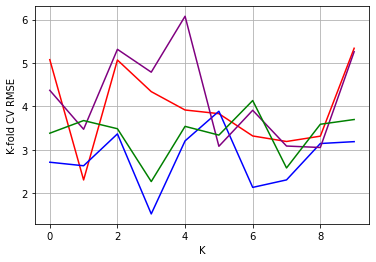

In [27]:
plt.plot(rmse_linearRegressionCV, color = 'red', label = 'Linear Regression')
plt.plot(rmse_randomforestCV, color = 'blue', label = 'Random Forest')
plt.plot(rmse_gamCV, color = 'purple', label = 'Generalized Additive Models')
plt.plot(rmse_lassoCV, color = 'green', label = 'Lasso Linear Regression')
plt.xlabel("K")
plt.ylabel("K-fold CV RMSE")
plt.grid(True)

In [28]:
print(rmse_lravg, rmse_forestavg, rmse_gamavg, rmse_lassoavg)

3.9692318060522425 2.8083498720391513 4.240391592522476 3.367514131252989


## T-test

In [29]:
def tTest(rmse1, rmse2):
    mean = (rmse1 - rmse2).mean()
    sd = (rmse1 - rmse2).std()
    t_statistic = mean / (sd / np.sqrt(10)) ## 여기 n에 10?????
    return t_statistic

**H0**: linear regression model의 rmse = Random Forest model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [30]:
mean = np.average(rmse_linearRegressionCV - rmse_randomforestCV)
sd = (rmse_linearRegressionCV - rmse_randomforestCV).std()

tTest(rmse_linearRegressionCV, rmse_randomforestCV)

3.5949940704538283

In [31]:
print(rmse_linearRegressionCV - rmse_randomforestCV)
print(mean)

[ 2.36398871 -0.32704569  1.70282782  2.81897861  0.71195474 -0.05520946
  1.18559457  0.88537104  0.16967213  2.15268687]
1.1608819340130914


t_0.025,9 = 2.262 <br><br>

|t-value| = 3.595 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, linear regression model과 Random forest model의 성능에는 차이가 있다. 

평균 차이가 양수이므로, linear 모델의 rmse가 더 높음을 알 수 있다. 따라서, random forest의 성능이 더 좋다.


**H0**: linear regression model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [32]:
mean = np.average(rmse_linearRegressionCV - rmse_gamCV)
sd = np.std(rmse_linearRegressionCV - rmse_gamCV)

tTest(rmse_linearRegressionCV, rmse_gamCV)

-1.0203254065244671

t_0.025,9 = 2.262 <br><br>

|t-value| = 1.02 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 GAM model의 성능에는 차이가 없다. 


**H0**: linear regression model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [33]:
mean = np.average(rmse_linearRegressionCV - rmse_lassoCV)
sd = (rmse_linearRegressionCV - rmse_lassoCV).std()

tTest(rmse_linearRegressionCV, rmse_lassoCV) 

1.7274384246911179

t_0.025,9 = 2.262 <br><br>

|t-value| = 1.727 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Lasso linear regression model의 성능에는 차이가 없다. 

**H0**: Random Forest model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [34]:
mean = np.average(rmse_randomforestCV - rmse_gamCV)
sd = (rmse_randomforestCV - rmse_gamCV).std()

tTest(rmse_randomforestCV, rmse_gamCV)

-3.773136842196244

In [35]:
print(rmse_randomforestCV - rmse_gamCV)
print(mean)

[-1.65737657 -0.84105299 -1.94919053 -3.26734665 -2.87309641  0.80743048
 -1.77765104 -0.78059167  0.09176985 -2.07331166]
-1.4320417204833242


t_0.025,9 = 2.262 <br><br>

|t-value| = 3.773 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, random forest model과 GAM model의 성능에는 차이가 있다. 이때 rf와 GAM의 cv rmse값을 뺀것이 음수이기때문에, rf의 rmse가 GAM의 rmse보다 작다. 즉, **rf 모델이 성능이 좋다. **


**H0**: Random Forest model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [36]:
mean = np.average(rmse_randomforestCV - rmse_lassoCV)
sd = (rmse_randomforestCV - rmse_lassoCV).std()

tTest(rmse_randomforestCV, rmse_lassoCV)

-2.819698835985774

In [37]:
print(rmse_randomforestCV - rmse_lassoCV)
print(mean)

[-0.66882789 -1.04164626 -0.11866655 -0.74581701 -0.33481951  0.54996254
 -2.00214206 -0.27532258 -0.4442935  -0.51006977]
-0.5591642592138376


t_0.025,9 = 2.262 <br><br>

|t-value| = 2.820 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, random forest model과 Lasso linear regression model의 성능에는 차이가 있다. 이때 rf와 lasso의 cv rmse값을 뺀것이 음수이기때문에, rf의 rmse가 lasso의 rmse보다 작다. 즉, **rf 모델이 lasso 모델보다 더 성능이 좋다. **


**H0**: GAM model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [38]:
mean = np.average(rmse_gamCV - rmse_lassoCV)
sd = (rmse_gamCV - rmse_lassoCV).std()

tTest(rmse_gamCV, rmse_lassoCV)

2.453881927284506

In [39]:
print(rmse_gamCV - rmse_lassoCV)
print(mean)

[ 0.98854869 -0.20059327  1.83052398  2.52152964  2.5382769  -0.25746794
 -0.22449102  0.50526909 -0.53606335  1.56324189]
0.8728774612694867


t_0.025,9 = 2.262 <br><br>

|t-value| = 2.454 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, GAM model과 Lasso linear regression model의 성능에는 차이가 있다. 이때 gam와 lasso의 cv rmse값을 뺀것이 양수이기때문에, lasso의 rmse가 gam의 rmse보다 작다. 즉, **lasso모델이 더 성능이 좋다.**

#### 6번의 T-검정 결과, 해당 데이터 분할 방법에서는 max_features=3, n_estimators=64, random_state=23, warm_start=True 파라미터의 random forest가 best이다.

## Testing

In [40]:
# 최종 선택 모델 재적합
model_final = RandomForestRegressor(max_features = 3, n_estimators = 64, warm_start = True, random_state = 23)
model_final.fit(X_train, y_train)

RandomForestRegressor(max_features=3, n_estimators=64, random_state=23,
                      warm_start=True)

In [41]:
y_pred = model_final.predict(X_test)

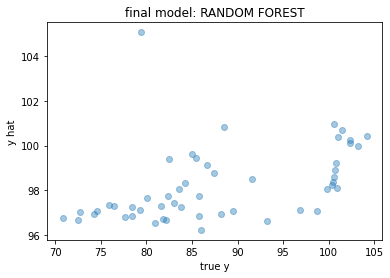

In [42]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("final model: RANDOM FOREST")
plt.show()

* model evaluating

In [43]:
print("R square: ", model_final.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred)))

R square:  0.9668845324072033
training RMSE:  1.017921155989808
test RMSE:  13.889244716850964
training MAE:  0.8686172229325868
test MAE:  3.380858205527459


## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [44]:
# scaling(X_train에 했던 scaling을 그대로 적용)
X = scaler.transform(predictors.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])

In [45]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_final.predict(X)

In [46]:
tmp = pd.merge(predictors, ccsi)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,93.575,94.619844
1,2016,1,11,770,348,351,626,182,58.0,25.16599,95.550,95.572969
2,2016,1,18,918,422,441,445,147,74.0,27.38639,97.525,97.896719
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.500,98.920937
4,2016,2,1,899,341,485,289,110,63.0,23.01888,99.040,98.403516


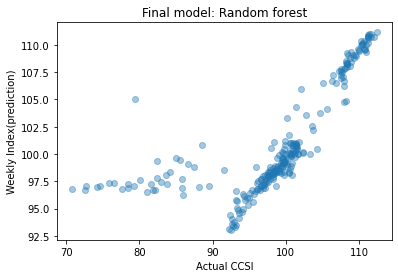

In [47]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("Final model: Random forest")
plt.show()

In [48]:
# weekly별 단기지표 값에 대한 RMSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

RMSE about weekly CCSI:  6.314111154904498


### visaulization
* 시계열 그래프

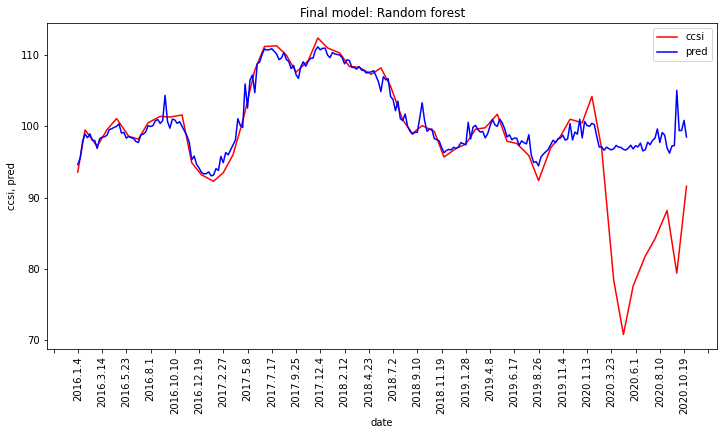

In [49]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("Final model: Random forest")
plt.legend()
plt.show()

* moving avg 시계열 그래프

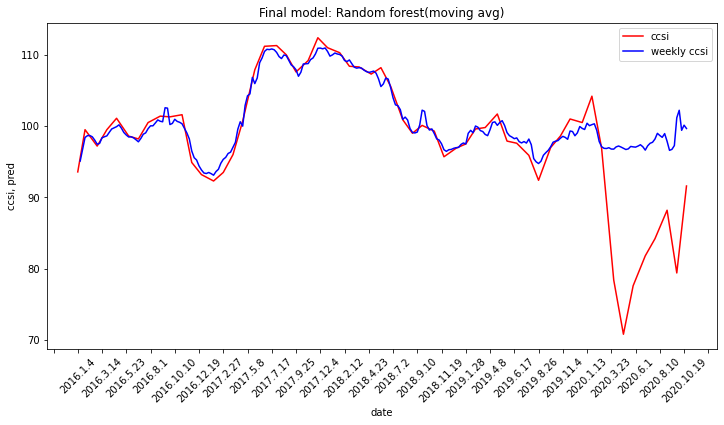

In [50]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("Final model: Random forest(moving avg)")
plt.legend()
plt.show()

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [51]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp[['date', 'weeklyCLI']]

,date,weeklyCLI
0,2016.1.4,94.619844
1,2016.1.11,95.096406
2,2016.1.18,96.734844
3,2016.1.25,98.408828
4,2016.2.1,98.662227
...,...,...
247,2020.9.28,101.176641
248,2020.10.5,102.223594
249,2020.10.12,99.410391
250,2020.10.19,100.132852
